## Model
Neurips Paper about ConvLSTM: https://proceedings.neurips.cc/paper_files/paper/2015/file/07563a3fe3bbe7e3ba84431ad9d055af-Paper.pdf

Enter a transformer research paper here..



In [3]:
# faster way to get the data since manual uplaod was taking way too long
!wget -c https://database.lichess.org/lichess_db_puzzle.csv.zst
!apt-get -qq update && apt-get -qq install -y zstd
!zstd -d lichess_db_puzzle.csv.zst -o lichess_db_puzzle.csv

--2025-05-01 04:47:29--  https://database.lichess.org/lichess_db_puzzle.csv.zst
Resolving database.lichess.org (database.lichess.org)... 141.95.66.62, 2001:41d0:700:5e3e::
Connecting to database.lichess.org (database.lichess.org)|141.95.66.62|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 247684364 (236M) [application/octet-stream]
Saving to: ‘lichess_db_puzzle.csv.zst’

lichess_db_puzzle.c 100%[===================>] 236.21M  19.1MB/s    in 14s     

2025-05-01 04:47:44 (17.0 MB/s) - ‘lichess_db_puzzle.csv.zst’ saved [247684364/247684364]

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
lichess_db_puzzle.csv.zst: 911966229 bytes 


In [4]:
pip install chess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 80.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chess: filename=chess-1.11.2-py3-none-any.whl size=147775 sha256=0c4ee3b26873a7bf79cd08cfa716780ad2e5dc7e527ba4730939510b3a4b9940
  Stored in directory: /root/.cache/pip/wheels/fb/5d/5c/59a62d8a695285e59ec9c1f66add6f8a9ac4152499a2be0113
Successfully built chess


In [5]:
import torch
import numpy as np
import chess
import chess.pgn
import chess.engine
import torch.nn as nn

# --- FEN to Tensor Encoding (12 channels: piece type x color) ---
piece_to_plane = {
    'P': 0, 'N': 1, 'B': 2, 'R': 3, 'Q': 4, 'K': 5,
    'p': 6, 'n': 7, 'b': 8, 'r': 9, 'q': 10, 'k': 11
}

def fen_to_tensor(fen):
    board = chess.Board(fen)
    tensor = np.zeros((12, 8, 8), dtype=np.float32)
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece:
            row = 7 - (square // 8)  # flip vertically to match tensor layout
            col = square % 8
            tensor[piece_to_plane[piece.symbol()], row, col] = 1.0
    return torch.tensor(tensor, dtype=torch.float32)

# --- Simple Feedforward Model ---
class TwoMoveMateSolver(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()                       # 12x8x8 → 768
        self.fc1 = nn.Linear(768, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.output = nn.Linear(512, 4 * 64)              # 4 softmax heads over 64 squares

    def forward(self, x):
        x = self.flatten(x)           # [B, 768]
        x = F.relu(self.fc1(x))       # [B, 1024]
        x = F.relu(self.fc2(x))       # [B, 512]
        x = self.output(x)            # [B, 256]
        x = x.view(-1, 4, 64)         # [B, 4 moves, 64-square choices]
        return x


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BoardTransformerMateSolver(nn.Module):
    def __init__(self,
                 d_model: int = 128,
                 nhead: int = 8,
                 num_layers: int = 4,
                 dim_feedforward: int = 256,
                 dropout: float = 0.1):
        super().__init__()

        self.input_proj = nn.Linear(12, d_model)

        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))

        self.pos_embed = nn.Parameter(torch.zeros(1, 65, d_model))

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.head = nn.Linear(d_model, 4 * 64)

        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.input_proj.weight, std=0.02)
        nn.init.zeros_(self.input_proj.bias)

    def forward(self, x):
        B = x.size(0)
        x = x.view(B, 12, 64).permute(0, 2, 1)

        x = self.input_proj(x)
        cls = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls, x], dim=1)

        x = x + self.pos_embed

        x = self.encoder(x)

        cls_out = x[:, 0]
        logits = self.head(cls_out)
        return logits.view(B, 4, 64)


## Dataset

In [7]:
import torch
import pandas as pd
import chess
from torch.utils.data import Dataset

class TwoMoveMateDataset(Dataset):
    def __init__(self, csv_path):
        self.df = pd.read_csv(csv_path)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        fen = row['fen']
        move1 = chess.Move.from_uci(row['move1'])
        move2 = chess.Move.from_uci(row['move2'])

        # Encode board state
        input_tensor = fen_to_tensor(fen)

        # Encode moves as 4 target indices: from1, to1, from2, to2
        label = torch.tensor([
            move1.from_square,
            move1.to_square,
            move2.from_square,
            move2.to_square
        ], dtype=torch.long)

        return input_tensor, label

In [ ]:
# class TwoMoveMateDatasetLSTM(Dataset):
#     def __init__(self, csv_path):
#         self.df = pd.read_csv(csv_path)

#     def __len__(self):
#         return len(self.df)

#     def __getitem__(self, idx):
#         row = self.df.iloc[idx]
#         fen = row['fen']
#         move1 = chess.Move.from_uci(row['move1'])
#         move2 = chess.Move.from_uci(row['move2'])

#         # You need two board states as input:
#         # 1. Original position
#         # 2. After move1 is played

#         board1 = chess.Board(fen)
#         input1 = fen_to_tensor(board1.fen())

#         board1.push(move1)
#         input2 = fen_to_tensor(board1.fen())

#         # Stack into a sequence: [2, C, 8, 8]
#         input_seq = torch.stack([input1, input2], dim=0)  # [2, C, 8, 8]

#         # Encode labels: [2] for two destination squares (or [2, 64] if you use from-to)
#         label = torch.tensor([
#             move1.to_square,
#             move2.to_square
#         ], dtype=torch.long)

#         return input_seq, label


## Train

In [13]:
# --- Hyperparameters
batch_size = 64
epochs = 50
lr = 3e-4

In [14]:
# --- Data
# from torch.utils.data import DataLoader

# # dataset = TwoMoveMateDataset('mate_in_2_simple.csv')
# dataset = TwoMoveMateDatasetLSTM('mate_in_2_simple.csv')
# loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

from torch.utils.data import random_split, DataLoader

# Load full dataset
dataset = TwoMoveMateDataset("mate_in_2_simple.csv")

# 80-20 split
total_size = len(dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size= batch_size, shuffle=False)

In [15]:
# --- Model and training setup
import glob
import os
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = TwoMoveMateSolver().to(device)
model = BoardTransformerMateSolver().to(device)

# checkpoint_files = glob.glob("convlstm_model_epoch*.pt")
# if checkpoint_files:
#     latest_checkpoint = max(checkpoint_files, key=os.path.getmtime)

#     model.load_state_dict(torch.load(latest_checkpoint, map_location=device))
#     print(f"Loaded model from {latest_checkpoint}")
# else:
#     print("No model checkpoint found, starting from scratch.")


optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()

In [17]:
from tqdm import tqdm
start_epoch = 0
total_epochs = epochs
train_acc_list = []
test_acc_list = []
for epoch in range(start_epoch, total_epochs):
    # ---- Training ----
    model.train()
    total_loss = 0
    correct_moves = 0
    total_moves = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1} [Train]"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = 0
        for i in range(2):
            loss += criterion(outputs[:, i, :], labels[:, i])
            preds = outputs[:, i, :].argmax(dim=1)
            correct_moves += (preds == labels[:, i]).sum().item()
            total_moves += labels.size(0)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    train_loss = total_loss / len(train_loader)
    train_acc = correct_moves / total_moves

    # ---- Evaluation ----
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc=f"Epoch {epoch + 1} [Test]"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)

            for i in range(2):
                test_loss += criterion(outputs[:, i, :], labels[:, i]).item()
                preds = outputs[:, i, :].argmax(dim=1)
                test_correct += (preds == labels[:, i]).sum().item()
                test_total += labels.size(0)

    test_loss /= len(test_loader)
    test_acc = test_correct / test_total

    print(f"Epoch {epoch + 1} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Test Loss: {test_loss:.4f}, Acc: {test_acc:.4f}")

    torch.save(model.state_dict(), f"transformer_model_epoch{epoch}.pt")


    # After each epoch
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)



Epoch 1 [Test]: 100%|██████████| 910/910 [00:11<00:00, 77.17it/s]


Epoch 1 | Train Loss: 5.8187, Acc: 0.2864 | Test Loss: 4.6242, Acc: 0.3800


Epoch 2 [Test]: 100%|██████████| 910/910 [00:11<00:00, 77.42it/s]


Epoch 2 | Train Loss: 4.5553, Acc: 0.3875 | Test Loss: 4.1213, Acc: 0.4310


Epoch 3 [Test]: 100%|██████████| 910/910 [00:11<00:00, 76.12it/s]


Epoch 3 | Train Loss: 4.1844, Acc: 0.4251 | Test Loss: 3.8581, Acc: 0.4572


Epoch 4 [Test]: 100%|██████████| 910/910 [00:11<00:00, 75.97it/s]


Epoch 4 | Train Loss: 3.9530, Acc: 0.4494 | Test Loss: 3.6707, Acc: 0.4817


Epoch 5 [Test]: 100%|██████████| 910/910 [00:12<00:00, 75.64it/s]


Epoch 5 | Train Loss: 3.7689, Acc: 0.4701 | Test Loss: 3.5103, Acc: 0.5001


Epoch 6 [Test]: 100%|██████████| 910/910 [00:11<00:00, 76.20it/s]


Epoch 6 | Train Loss: 3.6249, Acc: 0.4878 | Test Loss: 3.4065, Acc: 0.5133


Epoch 7 [Test]: 100%|██████████| 910/910 [00:11<00:00, 76.07it/s]


Epoch 7 | Train Loss: 3.5113, Acc: 0.5015 | Test Loss: 3.3556, Acc: 0.5166


Epoch 8 [Test]: 100%|██████████| 910/910 [00:11<00:00, 76.39it/s]


Epoch 8 | Train Loss: 3.4112, Acc: 0.5129 | Test Loss: 3.2417, Acc: 0.5311


Epoch 9 [Test]: 100%|██████████| 910/910 [00:11<00:00, 76.30it/s]


Epoch 9 | Train Loss: 3.3321, Acc: 0.5225 | Test Loss: 3.1755, Acc: 0.5421


Epoch 10 [Test]: 100%|██████████| 910/910 [00:11<00:00, 77.10it/s]


Epoch 10 | Train Loss: 3.2587, Acc: 0.5316 | Test Loss: 3.1361, Acc: 0.5469


Epoch 11 [Test]: 100%|██████████| 910/910 [00:11<00:00, 76.34it/s]


Epoch 11 | Train Loss: 3.1953, Acc: 0.5393 | Test Loss: 3.0916, Acc: 0.5532


Epoch 12 [Test]: 100%|██████████| 910/910 [00:11<00:00, 76.83it/s]


Epoch 12 | Train Loss: 3.1448, Acc: 0.5459 | Test Loss: 3.0480, Acc: 0.5574


Epoch 13 [Test]: 100%|██████████| 910/910 [00:11<00:00, 76.64it/s]


Epoch 13 | Train Loss: 3.0956, Acc: 0.5520 | Test Loss: 3.0091, Acc: 0.5620


Epoch 14 [Test]: 100%|██████████| 910/910 [00:11<00:00, 76.68it/s]


Epoch 14 | Train Loss: 3.0489, Acc: 0.5576 | Test Loss: 3.0064, Acc: 0.5616


Epoch 15 [Test]: 100%|██████████| 910/910 [00:11<00:00, 76.16it/s]


Epoch 15 | Train Loss: 3.0081, Acc: 0.5625 | Test Loss: 2.9777, Acc: 0.5660


Epoch 16 [Test]: 100%|██████████| 910/910 [00:11<00:00, 76.70it/s]


Epoch 16 | Train Loss: 2.9735, Acc: 0.5671 | Test Loss: 2.9334, Acc: 0.5717


Epoch 17 [Test]: 100%|██████████| 910/910 [00:11<00:00, 77.63it/s]


Epoch 17 | Train Loss: 2.9373, Acc: 0.5719 | Test Loss: 2.9352, Acc: 0.5728


Epoch 18 [Test]: 100%|██████████| 910/910 [00:11<00:00, 76.57it/s]


Epoch 18 | Train Loss: 2.9089, Acc: 0.5752 | Test Loss: 2.9043, Acc: 0.5769


Epoch 19 [Test]: 100%|██████████| 910/910 [00:11<00:00, 76.42it/s]


Epoch 19 | Train Loss: 2.8795, Acc: 0.5789 | Test Loss: 2.8982, Acc: 0.5785


Epoch 20 [Test]: 100%|██████████| 910/910 [00:11<00:00, 77.07it/s]


Epoch 20 | Train Loss: 2.8499, Acc: 0.5830 | Test Loss: 2.8599, Acc: 0.5813


Epoch 21 [Test]: 100%|██████████| 910/910 [00:11<00:00, 76.90it/s]


Epoch 21 | Train Loss: 2.8292, Acc: 0.5846 | Test Loss: 2.8653, Acc: 0.5820


Epoch 22 [Test]: 100%|██████████| 910/910 [00:11<00:00, 76.33it/s]


Epoch 22 | Train Loss: 2.7995, Acc: 0.5891 | Test Loss: 2.8598, Acc: 0.5849


Epoch 23 [Test]: 100%|██████████| 910/910 [00:11<00:00, 76.92it/s]


Epoch 23 | Train Loss: 2.7809, Acc: 0.5913 | Test Loss: 2.8609, Acc: 0.5842


Epoch 24 [Test]: 100%|██████████| 910/910 [00:11<00:00, 77.32it/s]


Epoch 24 | Train Loss: 2.7563, Acc: 0.5947 | Test Loss: 2.8287, Acc: 0.5882


Epoch 25 [Test]: 100%|██████████| 910/910 [00:11<00:00, 76.21it/s]


Epoch 25 | Train Loss: 2.7340, Acc: 0.5980 | Test Loss: 2.8269, Acc: 0.5893


Epoch 26 [Test]: 100%|██████████| 910/910 [00:11<00:00, 76.47it/s]


Epoch 26 | Train Loss: 2.7153, Acc: 0.5997 | Test Loss: 2.8199, Acc: 0.5914


Epoch 27 [Test]: 100%|██████████| 910/910 [00:11<00:00, 77.12it/s]


Epoch 27 | Train Loss: 2.6962, Acc: 0.6031 | Test Loss: 2.8122, Acc: 0.5890


Epoch 28 [Test]: 100%|██████████| 910/910 [00:11<00:00, 76.87it/s]


Epoch 28 | Train Loss: 2.6821, Acc: 0.6042 | Test Loss: 2.7923, Acc: 0.5936


Epoch 29 [Test]: 100%|██████████| 910/910 [00:11<00:00, 76.80it/s]


Epoch 29 | Train Loss: 2.6644, Acc: 0.6072 | Test Loss: 2.7713, Acc: 0.5932


Epoch 30 [Test]: 100%|██████████| 910/910 [00:11<00:00, 76.09it/s]


Epoch 30 | Train Loss: 2.6468, Acc: 0.6086 | Test Loss: 2.8065, Acc: 0.5908


Epoch 31 [Test]: 100%|██████████| 910/910 [00:11<00:00, 77.01it/s]


Epoch 31 | Train Loss: 2.6243, Acc: 0.6119 | Test Loss: 2.7933, Acc: 0.5927


Epoch 32 [Test]: 100%|██████████| 910/910 [00:11<00:00, 76.38it/s]


Epoch 32 | Train Loss: 2.6175, Acc: 0.6135 | Test Loss: 2.8029, Acc: 0.5944


Epoch 33 [Test]: 100%|██████████| 910/910 [00:11<00:00, 76.75it/s]


Epoch 33 | Train Loss: 2.5973, Acc: 0.6156 | Test Loss: 2.7651, Acc: 0.5978


Epoch 34 [Test]: 100%|██████████| 910/910 [00:11<00:00, 77.13it/s]


Epoch 34 | Train Loss: 2.5839, Acc: 0.6175 | Test Loss: 2.7794, Acc: 0.5957


Epoch 35 [Test]: 100%|██████████| 910/910 [00:11<00:00, 76.47it/s]


Epoch 35 | Train Loss: 2.5675, Acc: 0.6187 | Test Loss: 2.7784, Acc: 0.5955


Epoch 36 [Test]: 100%|██████████| 910/910 [00:11<00:00, 76.58it/s]


Epoch 36 | Train Loss: 2.5574, Acc: 0.6202 | Test Loss: 2.7716, Acc: 0.6008


Epoch 37 [Test]: 100%|██████████| 910/910 [00:11<00:00, 76.46it/s]


Epoch 37 | Train Loss: 2.5462, Acc: 0.6220 | Test Loss: 2.7689, Acc: 0.5996


Epoch 38 [Test]: 100%|██████████| 910/910 [00:11<00:00, 76.67it/s]


Epoch 38 | Train Loss: 2.5337, Acc: 0.6241 | Test Loss: 2.7598, Acc: 0.6002


Epoch 39 [Test]: 100%|██████████| 910/910 [00:11<00:00, 77.00it/s]


Epoch 39 | Train Loss: 2.5202, Acc: 0.6259 | Test Loss: 2.7572, Acc: 0.6039


Epoch 40 [Test]: 100%|██████████| 910/910 [00:11<00:00, 76.39it/s]


Epoch 40 | Train Loss: 2.5086, Acc: 0.6274 | Test Loss: 2.7371, Acc: 0.6031


Epoch 41 [Test]: 100%|██████████| 910/910 [00:11<00:00, 77.37it/s]


Epoch 41 | Train Loss: 2.4956, Acc: 0.6288 | Test Loss: 2.7565, Acc: 0.6000


Epoch 42 [Test]: 100%|██████████| 910/910 [00:11<00:00, 76.23it/s]


Epoch 42 | Train Loss: 2.4894, Acc: 0.6300 | Test Loss: 2.7524, Acc: 0.6028


Epoch 43 [Test]: 100%|██████████| 910/910 [00:11<00:00, 76.79it/s]


Epoch 43 | Train Loss: 2.4720, Acc: 0.6318 | Test Loss: 2.7700, Acc: 0.6018


Epoch 44 [Test]: 100%|██████████| 910/910 [00:12<00:00, 75.82it/s]


Epoch 44 | Train Loss: 2.4653, Acc: 0.6331 | Test Loss: 2.7516, Acc: 0.6020


Epoch 45 [Test]: 100%|██████████| 910/910 [00:11<00:00, 76.56it/s]


Epoch 45 | Train Loss: 2.4512, Acc: 0.6352 | Test Loss: 2.7435, Acc: 0.6042


Epoch 46 [Test]: 100%|██████████| 910/910 [00:11<00:00, 76.48it/s]


Epoch 46 | Train Loss: 2.4403, Acc: 0.6367 | Test Loss: 2.7530, Acc: 0.6041


Epoch 47 [Test]: 100%|██████████| 910/910 [00:11<00:00, 76.12it/s]


Epoch 47 | Train Loss: 2.4316, Acc: 0.6373 | Test Loss: 2.7430, Acc: 0.6032


Epoch 48 [Test]: 100%|██████████| 910/910 [00:11<00:00, 76.45it/s]


Epoch 48 | Train Loss: 2.4261, Acc: 0.6374 | Test Loss: 2.7696, Acc: 0.6017


Epoch 49 [Test]: 100%|██████████| 910/910 [00:11<00:00, 75.98it/s]


Epoch 49 | Train Loss: 2.4186, Acc: 0.6391 | Test Loss: 2.7127, Acc: 0.6078


Epoch 50 [Test]: 100%|██████████| 910/910 [00:11<00:00, 76.80it/s]

Epoch 50 | Train Loss: 2.4041, Acc: 0.6412 | Test Loss: 2.7501, Acc: 0.6070


## Visualizing Performance

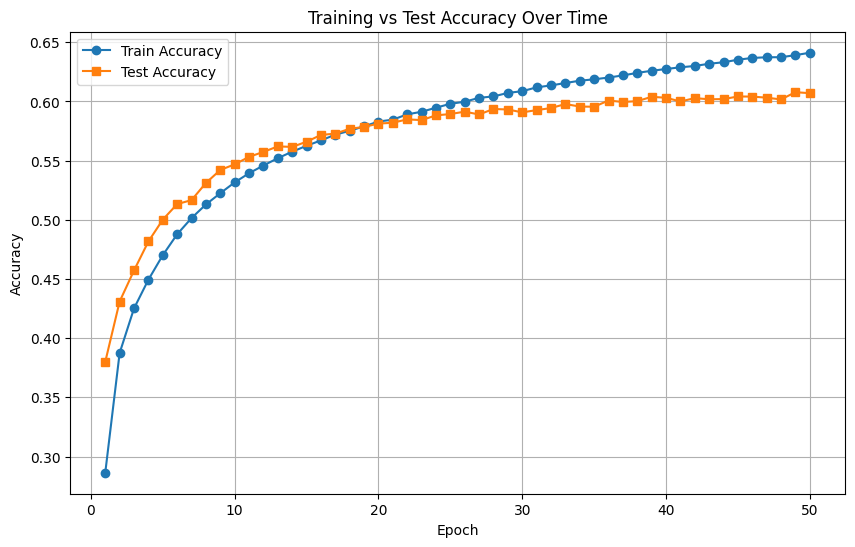

In [18]:
import matplotlib.pyplot as plt

epochs = list(range(start_epoch + 1, start_epoch + 1 + len(train_acc_list)))
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc_list, label="Train Accuracy", marker='o')
plt.plot(epochs, test_acc_list, label="Test Accuracy", marker='s')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Test Accuracy Over Time")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
## Old code for the naive approach
# for epoch in range(epochs):
#     model.train()
#     total_loss = 0
#     correct_moves = 0
#     total_moves = 0

#     for inputs, labels in loader:
#         inputs = inputs.to(device)
#         labels = labels.to(device)

#         optimizer.zero_grad()
#         output = model(inputs)  # shape: [B, 4, 64]

#         loss = 0
#         for i in range(4):
#             loss += criterion(output[:, i, :], labels[:, i])
#             preds = output[:, i, :].argmax(dim=1)
#             correct_moves += (preds == labels[:, i]).sum().item()
#             total_moves += labels.size(0)

#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()

#     avg_loss = total_loss / len(loader)
#     accuracy = correct_moves / (total_moves)
#     print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f} | Accuracy: {accuracy:.4f}")
#     torch.save(model.state_dict(), f"convlstm_model_{epoch}.pt")
#     print(f"Model saved as 'convlstm_model_{epoch}.pt'")

## Convert to just Mate in 2 csv

In [9]:
# Load the Lichess puzzle CSV (decompressed)
df = pd.read_csv("lichess_db_puzzle.csv", low_memory=False)

# Step 1: Filter for mate-in-2 puzzles
df = df[df["Themes"].str.contains("mateIn2", na=False)]

# Step 2: Keep only puzzles where White moves first
df = df[df["FEN"].str.split().str[1] == "w"]

# Step 3: Get player's first and second moves (0 and 2)
df["move_list"] = df["Moves"].str.split()
df = df[df["move_list"].str.len() >= 3]
df["move1"] = df["move_list"].apply(lambda m: m[0])
df["move2"] = df["move_list"].apply(lambda m: m[2])

# Step 4: Save just the FEN and two moves
df = df[["FEN", "move1", "move2"]].rename(columns={"FEN": "fen"})
df.to_csv("mate_in_2_simple.csv", index=False)